In [1]:
%pylab inline
import glob, os, sys, fnmatch
from astropy.io import fits
import astropy.table
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate 
import pandas as pd
import astropy.table
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', size=10, family='serif')

In [3]:
from lmfit import models, Parameters, Parameter, Model
from lmfit.models import LinearModel, ConstantModel

In [4]:
%load_ext autoreload
%autoreload 2

In [24]:
spdata_dir = '/Volumes/PFagrelius_Backup/sky_data/sky_flux/'

In [5]:
cont_files = glob.glob('/Users/parkerf/Research/SkyModel/BOSS_Sky/FitSpectra/split_files/*_split_flux.fits')

In [6]:
Data = astropy.table.Table.read('/Users/parkerf/Research/SkyModel/SkyModelling/spframe_line_sum.fits')

In [12]:
len(Data)//2

1243966

In [13]:
np.array(Data.dtype.names)

array(['PLATE', 'SPECNO', 'IMG', 'FIB', 'XFOCAL', 'YFOCAL', 'FIBER_RA',
       'FIBER_DEC', 'OBJTYPE', 'MJD', 'TAI-BEG', 'TAI-END', 'RA', 'DEC',
       'CAMERAS', 'AIRMASS', 'ALT', 'AZ', 'EXPTIME', 'SEEING20',
       'SEEING50', 'SEEING80', 'RMSOFF20', 'RMSOFF50', 'RMSOFF80',
       'DATE-OBS', 'REDDEN01', 'REDDEN02', 'REDDEN03', 'REDDEN04',
       'REDDEN05', 'QUALITY', 'DUSTC', 'DUSTD', 'AIRTEMP', 'DEWPOINT',
       'DUSTA', 'DUSTB', 'GUSTD', 'GUSTS', 'HUMIDITY', 'PRESSURE', 'WINDD',
       'WINDS', 'OBS_ZENITH', 'ECL_LAT', 'ECL_LON', 'GAL_LAT', 'GAL_LON',
       'MOOND', 'MOON_SEP', 'MOON_ALT', 'MOON_AZ', 'MOON_ZENITH',
       'MOON_ILL', 'MOON_PHASE', 'SUN_SEP', 'SUN_ALT', 'SUN_AZ',
       'SUN_MOON_SEP', 'MONTH', 'HOUR', 'PHOTO', 'SOLARFLUX', 'cont_bD',
       'Hg', 'OI', 'cont_bC', 'cont_bB', 'cont_rB', 'cont_rD', 'red_D',
       'OH', 'B', 'cont_rA', 'mean_OH', 'mean_B', 'mean_cont_rA',
       'mean_red_D', 'mean_cont_rD', 'mean_cont_rB', 'mean_cont_bC',
       'mean_OI', 'mean_

In [14]:
np.unique(Data[Data['PLATE'] == 3981]['MJD'])

55295.0
55603.0


## Take a look at Outliers

In [16]:
Outliersb = Data[np.abs(Data['mean_cont_bB'] - Data['cont_bB']) > 2*Data['mean_cont_bB']]
Outliersr = Data[np.abs(Data['mean_cont_rB'] - Data['cont_rB']) > 2*Data['mean_cont_rB']]

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [23]:
len(Outliersb)

120

In [18]:
#If a plate is bad, does that mean each image in it is bad?
R = []
for plate in np.unique(Outliersb['PLATE']):
    PlateData = Data[Data['PLATE'] == plate]
    OutData = Outliersb[Outliersb['PLATE'] == plate]
    R.append([plate, len(np.unique(PlateData['IMG'])), len(np.unique(OutData['IMG']))])

In [21]:
df = pd.DataFrame(R, columns = ('Plate','Tot Img','Bad Img'))
print(df)

    Plate  Tot Img  Bad Img
0    3842        6        4
1    4289        4        4
2    4391        7        2
3    4490       12        3
4    4645        4        4
5    4739        5        5
6    4767        6        6
7    4799        5        2
8    4854        5        5
9    4893        4        3
10   4969        3        1
11   5377        4        4
12   5745        6        3
13   5904        3        2
14   5943        7        4
15   5972        7        3
16   6300       10        2
17   6306        8        3
18   6437        4        4
19   6478        5        2
20   6491        4        3
21   6495        4        3
22   6498        3        2
23   7117        6        6
24   7149        4        2
25   7181        5        4
26   7253        7        7
27   7258        6        6
28   7259        5        5
29   7261        5        3
30   7333        8        4
31   7409        3        3


In [20]:
dif = df[df['Tot Img'] != df['Bad Img']]
print(dif)

   Plate  Tot Img  Bad Img
0   3842        6        4
2   4391        7        2
3   4490       12        3
7   4799        5        2
9   4893        4        3


20

In [60]:
# How many sky fibers are bad?
R1 = []
for image in np.unique(Outliersb['IMG']):
    PlateData = Data[Data['IMG'] == image]
    OutData = Outliersb[Outliersb['IMG'] == image]
    R1.append([PlateData['PLATE'][0], image, len(np.unique(PlateData['FIB'])), len(np.unique(OutData['FIB']))])

In [67]:
df1 = pd.DataFrame(R1, columns = ('Plate','Image', 'Tot Fib', 'Bad Fib'))
print(len(df1))

657


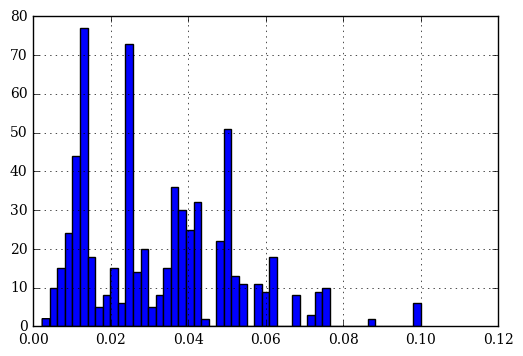

In [68]:
df1['ratio'] = df1['Bad Fib']/df1['Tot Fib']
df1['ratio'].hist(bins = 50)

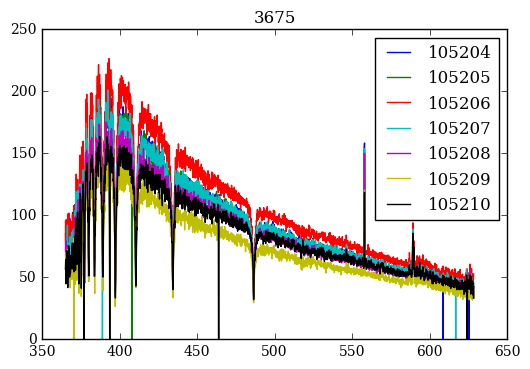

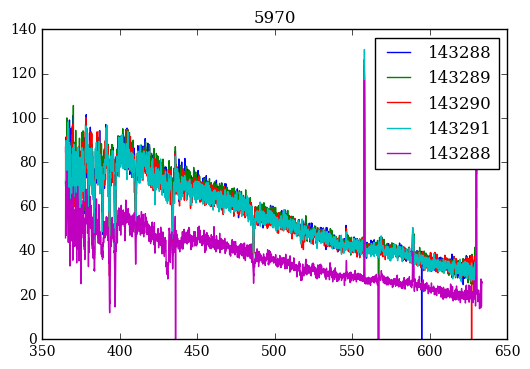

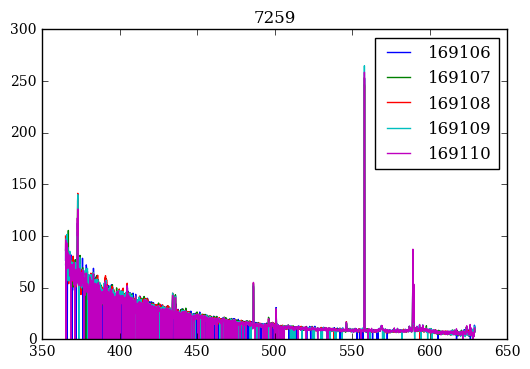

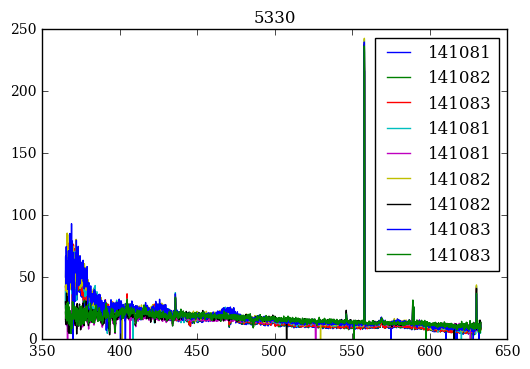

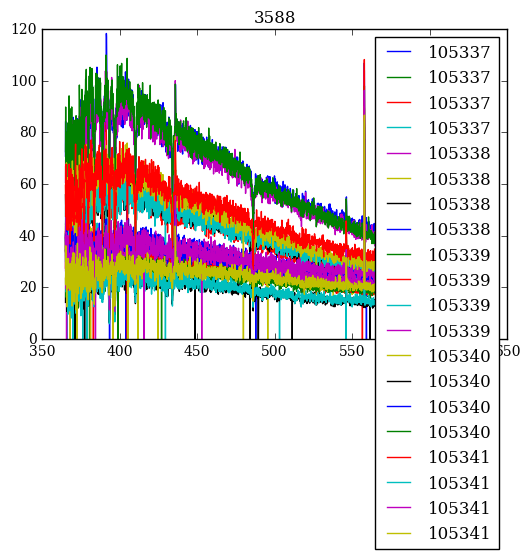

In [72]:
#Now we need to look at them and see if they are just mis-identified
for plate in np.random.choice(np.unique(Outliersb['PLATE']),5):
    plt.figure()
    data = np.load(spdata_dir+'%d_calibrated_sky.npy'% plate)
    lines = Outliersb[Outliersb['PLATE']==plate]
    for line in lines:
        spectrum = data[line['SPECNO']]
        plt.plot(spectrum['WAVE'], spectrum['SKY'], label = line['IMG'])
    plt.title(plate)
    plt.legend()

Now create a dictionary so we can see if they are mis-identified in the spFrame files

In [73]:
Outlier_Dict = {}
for plate in np.unique(Outliersb['PLATE']):
    Outlier_Dict[plate] = {}
    for image in np.unique(Outliersb[Outliersb['PLATE'] == plate]['IMG']):
        lines = Outliersb[Outliersb['IMG']== image]
        Outlier_Dict[plate][image] = np.unique(lines['FIB'])

In [77]:
import pickle
pickle.dump(Outlier_Dict,open('outlier_dict.pkl','wb'))

Check of the opposite is tru

In [78]:
Inliersb = Data[np.abs(Data['mean_bB'] - Data['bB']) < 2*Data['mean_bB']]
Inlier_Dict = {}
for plate in np.unique(Outliersb['PLATE']):
    Inlier_Dict[plate] = {}
    for image in np.unique(Outliersb[Outliersb['PLATE'] == plate]['IMG']):
        lines = Inliersb[Inliersb['IMG']== image]
        Inlier_Dict[plate][image] = np.unique(lines['FIB'])

In [79]:
pickle.dump(Inlier_Dict,open('inlier_dict.pkl','wb'))

In [ ]:
hdu[0]